# EduPredict Development Notebook

This notebook implements the data pipeline refinement and model optimization for the Early Warning Academic Performance Prediction system.

## Overview

1. Data Loading and Processing
2. Exploratory Data Analysis
3. Feature Engineering
4. Model Development (Random Forest Path)
5. Hyperparameter Tuning
6. Fairness Analysis

## Import Project Modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings

# suppress warnings
warnings.filterwarnings('ignore')

# set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

# add project root to python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_root)

In [2]:
# import from modules
from data_processing.data_processing import (
    load_raw_datasets, 
    clean_demographic_data, 
    clean_vle_data, 
    clean_assessment_data, 
    validate_data_consistency
)

from data_processing.feature_engineering import (
    create_demographic_features,
    create_temporal_features,
    create_assessment_features,
    create_sequential_features,
    prepare_dual_path_features,
    create_stratified_splits,
    prepare_target_variable
)

from data_analysis.eda import (
    perform_automated_eda,
    analyze_student_performance,
    analyze_engagement_patterns,
    document_eda_findings,
    visualize_demographic_distributions
)

from evaluation.performance_metrics import (
    analyze_feature_importance,
    analyze_feature_correlations,
    calculate_model_metrics,
    calculate_fairness_metrics,
    plot_roc_curves,
    plot_fairness_metrics
)

from model_training.hyperparameter_tuning import (
    tune_random_forest,
    visualize_tuning_results
)

## 1. Data Loading and Processing

Load the OULAD dataset files using memory-optimized strategies.

In [7]:
# current working directory
print("Working directory:", os.getcwd())

# check project root data directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
data_path = os.path.join(project_root, "data", "OULAD")
print("Project root data path:", data_path)

# list contents
if os.path.exists(data_path):
    print("Contents:", os.listdir(data_path))

Working directory: /Users/dylantadas/Desktop/spring 25/i494- capstone project/local repository/EduPredict/notebooks/model_development
Project root data path: /Users/dylantadas/Desktop/spring 25/i494- capstone project/local repository/EduPredict/data/OULAD
Contents: ['studentAssessment.csv', 'studentInfo.csv', 'studentVle.csv', 'courses.csv', 'vle.csv', 'studentRegistration.csv', 'assessments.csv']


In [17]:
# load datasets using optimized loading function
try:
    # load datasets
    datasets = load_raw_datasets(data_path)
    print("Dataset keys:", list(datasets.keys()))

    # verify data consistency
    if validate_data_consistency(datasets):
        print("Data consistency validation passed.")
    else:
        print("Data consistency validation failed.")
except Exception as e:
    print(f"Error loading datasets: {str(e)}")

Loaded studentInfo.csv: 32593 rows, 12 columns
Loaded studentVle.csv: 10655280 rows, 6 columns
Loaded vle.csv: 6364 rows, 6 columns
Loaded assessments.csv: 206 rows, 6 columns
Loaded studentAssessment.csv: 173912 rows, 5 columns
Loaded courses.csv: 22 rows, 3 columns

Total rows loaded across all files: 10,868,377
Dataset keys: ['student_info', 'vle_interactions', 'vle_materials', 'assessments', 'student_assessments', 'courses']
Data consistency validation passed.


In [18]:
# display dataset shapes
for name, df in datasets.items():
    print(f"{name}: {df.shape}")

student_info: (32593, 12)
vle_interactions: (10655280, 6)
vle_materials: (6364, 6)
assessments: (206, 6)
student_assessments: (173912, 5)
courses: (22, 3)


## Clean Datasets

Apply cleaning functions to each dataset component.

In [19]:
# clean demographic data
clean_demographics = clean_demographic_data(datasets['student_info'])
print(f"Clean demographics shape: {clean_demographics.shape}")

# clean vle data
clean_vle = clean_vle_data(datasets['vle_interactions'], datasets['vle_materials'])
print(f"Clean VLE data shape: {clean_vle.shape}")

# clean assessment data
clean_assessments = clean_assessment_data(datasets['assessments'], datasets['student_assessments'])
print(f"Clean assessment data shape: {clean_assessments.shape}")

Clean demographics shape: (32593, 12)
Clean VLE data shape: (10655280, 9)
Clean assessment data shape: (173739, 10)


## 2. Exploratory Data Analysis

Perform automated EDA to understand data characteristics and identify patterns.

In [20]:
# run automated eda on clean datasets
clean_datasets = {
    'student_info': clean_demographics,
    'vle': clean_vle,
    'assessments': clean_assessments
}

# get documented findings
eda_findings = document_eda_findings(clean_datasets)

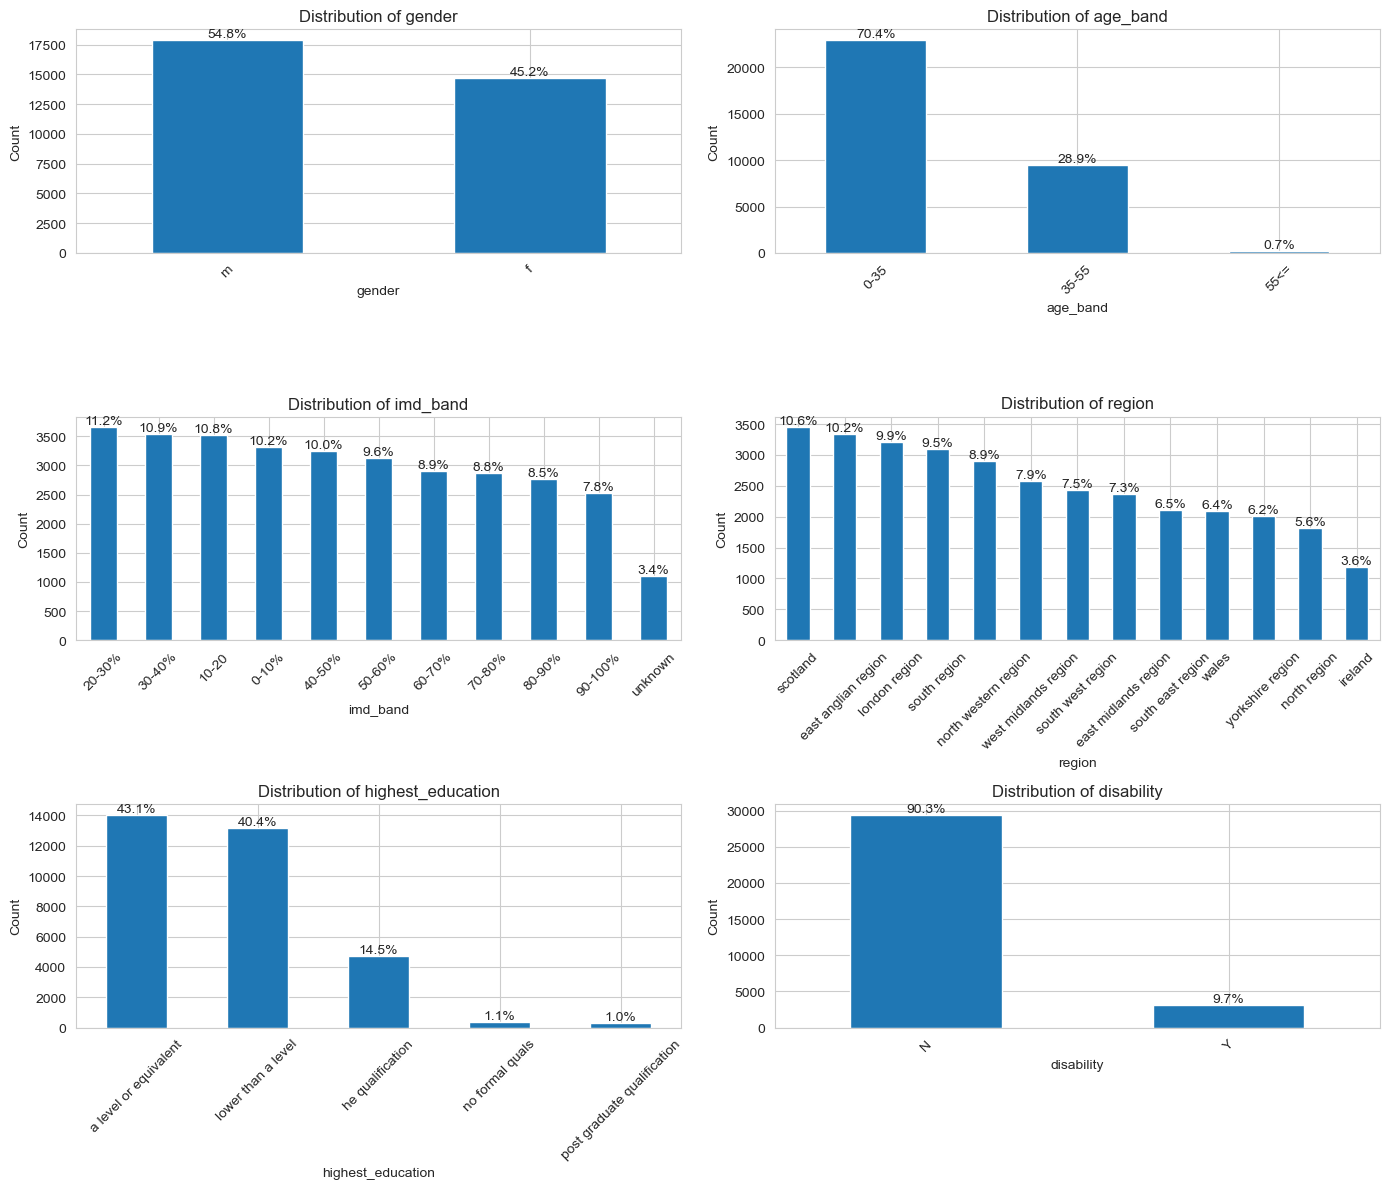

In [22]:
# visualize demographic distributions
visualize_demographic_distributions(clean_demographics)

In [23]:
# examine performance patterns by demographic group
# combine demographic and assessment data
demo_assessment = clean_demographics.merge(
    clean_assessments,
    on=['id_student', 'code_module', 'code_presentation'],
    how='inner'
)

# analyze performance across demographic groups
for col in ['gender', 'age_band', 'imd_band']:
    if col in demo_assessment.columns:
        print(f"\nAverage score by {col}:")
        print(demo_assessment.groupby(col, observed=False)['score'].mean().sort_values())


Average score by gender:
gender
m    75.695464
f    75.921683
Name: score, dtype: float64

Average score by age_band:
age_band
0-35     74.986198
35-55    77.530956
55<=     79.683391
Name: score, dtype: float64

Average score by imd_band:
imd_band
0-10%      72.685422
10-20      73.684782
20-30%     74.856424
30-40%     75.236042
50-60%     75.806767
40-50%     75.860245
60-70%     76.252415
70-80%     76.473202
80-90%     77.773063
90-100%    78.028356
unknown    79.158134
Name: score, dtype: float64


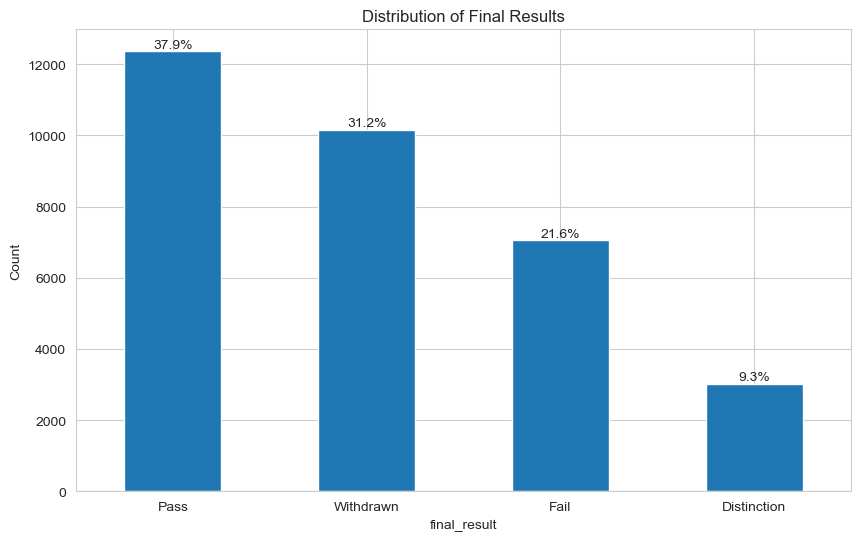

In [24]:
# examine final result distribution
if 'final_result' in clean_demographics.columns:
    plt.figure(figsize=(10, 6))
    result_counts = clean_demographics['final_result'].value_counts()
    result_counts.plot(kind='bar')
    plt.title('Distribution of Final Results')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    # add percentage labels
    total = result_counts.sum()
    for i, count in enumerate(result_counts):
        plt.text(i, count + 100, f'{100 * count / total:.1f}%', ha='center')
    
    plt.show()

## 3. Feature Engineering

Create features for both paths of the dual-path architecture.

In [25]:
# create demographic features
demographic_features = create_demographic_features(clean_demographics)
print(f"Demographic features shape: {demographic_features.shape}")

# display sample of demographic features
demographic_features.head()

Demographic features shape: (32593, 48)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_encoded,gender_m,region_encoded,region_east midlands region,region_ireland,region_london region,region_north region,region_north western region,region_scotland,region_south east region,region_south region,region_south west region,region_wales,region_west midlands region,region_yorkshire region,highest_education_encoded,highest_education_he qualification,highest_education_lower than a level,highest_education_no formal quals,highest_education_post graduate qualification,imd_band_encoded,imd_band_10-20,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_unknown,age_band_encoded,age_band_35-55,age_band_55<=,is_first_attempt,credit_density
0,AAA,2013J,11391,m,east anglian region,he qualification,90-100%,55<=,0,240,N,Pass,1,True,0,False,False,False,False,False,False,False,False,False,False,False,False,1,True,False,False,False,9,False,False,False,False,False,False,False,False,True,False,2,False,True,True,240.0
1,AAA,2013J,28400,f,scotland,he qualification,20-30%,35-55,0,60,N,Pass,0,False,6,False,False,False,False,False,True,False,False,False,False,False,False,1,True,False,False,False,2,False,True,False,False,False,False,False,False,False,False,1,True,False,True,60.0
2,AAA,2013J,30268,f,north western region,a level or equivalent,30-40%,35-55,0,60,Y,Withdrawn,0,False,5,False,False,False,False,True,False,False,False,False,False,False,False,0,False,False,False,False,3,False,False,True,False,False,False,False,False,False,False,1,True,False,True,60.0
3,AAA,2013J,31604,f,south east region,a level or equivalent,50-60%,35-55,0,60,N,Pass,0,False,7,False,False,False,False,False,False,True,False,False,False,False,False,0,False,False,False,False,5,False,False,False,False,True,False,False,False,False,False,1,True,False,True,60.0
4,AAA,2013J,32885,f,west midlands region,lower than a level,50-60%,0-35,0,60,N,Pass,0,False,11,False,False,False,False,False,False,False,False,False,False,True,False,2,False,True,False,False,5,False,False,False,False,True,False,False,False,False,False,0,False,False,True,60.0


In [26]:
# create temporal features with multiple window sizes
window_sizes = [7, 14, 30]  # weekly, bi-weekly, monthly
temporal_features = create_temporal_features(clean_vle, window_sizes)

# display info about temporal features
for window_size, features in temporal_features.items():
    print(f"{window_size} features shape: {features.shape}")

window_7 features shape: (627031, 28)
window_14 features shape: (376919, 28)
window_30 features shape: (204359, 28)


In [27]:
# create assessment features
assessment_features = create_assessment_features(clean_assessments)
print(f"Assessment features shape: {assessment_features.shape}")

# display sample of assessment features
assessment_features.head()

Assessment features shape: (25820, 13)


,id_student,code_module,code_presentation,score_mean,score_std,score_min,score_max,score_count,submission_delay_mean,submission_delay_std,is_banked_sum,weighted_score,submission_consistency
0,6516,AAA,2014J,61.800000,10.329569,48.0,77.0,5,-2.600000,1.516575,0,63.50,-0.583298
1,8462,DDD,2013J,87.666667,5.033223,83.0,93.0,3,-0.333333,3.785939,0,87.25,-11.357817
2,8462,DDD,2014J,86.500000,4.725816,83.0,93.0,4,-59.500000,38.974351,4,86.00,-0.655031
3,11391,AAA,2013J,82.000000,3.082207,78.0,85.0,5,-1.800000,0.836660,0,82.40,-0.464811
4,23629,BBB,2013B,82.500000,20.273135,63.0,100.0,4,3.500000,9.433981,0,66.76,2.695423


In [28]:
# create sequential features for gru path
sequential_features = create_sequential_features(clean_vle)
print(f"Sequential features shape: {sequential_features.shape}")

Sequential features shape: (10655280, 13)


In [31]:
# prepare dual path features
dual_path_features = prepare_dual_path_features(
    demographic_features, 
    temporal_features,
    assessment_features,
    sequential_features
)

# check shapes of dual path features
for path_name, features in dual_path_features.items():
    print(f"{path_name} shape: {features.shape}")

static_path shape: (25820, 58)
sequential_path shape: (9975445, 37)


## Prepare Target Variable

Create binary target variable: at-risk (1) vs. not-at-risk (0) students.

In [32]:
# create binary target variable
static_features = dual_path_features['static_path']
y = prepare_target_variable(static_features)

# check target distribution
target_counts = y.value_counts()
print("Target distribution:")
print(target_counts)
print(f"Percentage at risk: {100 * target_counts.get(1, 0) / len(y):.2f}%")

Target distribution:
final_result
0.0    15382
1.0     5765
Name: count, dtype: int64
Percentage at risk: 22.33%


## Create Stratified Train/Test Splits

Create train/test splits while preserving demographic distributions.

In [33]:
# create stratified splits
split_data = create_stratified_splits(dual_path_features, test_size=0.2, random_state=42)


Verifying demographic distribution in train/test splits:

Distribution of gender in training set:
gender
m    0.549799
f    0.450201
Name: proportion, dtype: float64

Distribution of gender in test set:
gender
m    0.553138
f    0.446862
Name: proportion, dtype: float64

Distribution of age_band in training set:
age_band
0-35     0.694336
35-55    0.298409
55<=     0.007256
Name: proportion, dtype: float64

Distribution of age_band in test set:
age_band
0-35     0.694070
35-55    0.298999
55<=     0.006931
Name: proportion, dtype: float64

Distribution of imd_band in training set:
imd_band
30-40%     0.107870
20-30%     0.106177
10-20      0.100808
40-50%     0.098679
50-60%     0.098534
0-10%      0.093213
60-70%     0.092633
70-80%     0.092439
80-90%     0.088134
90-100%    0.082717
unknown    0.038795
Name: proportion, dtype: float64

Distribution of imd_band in test set:
imd_band
20-30%     0.107239
30-40%     0.106854
10-20      0.100308
40-50%     0.099538
50-60%     0.098575
0

In [34]:
# prepare data for static path modeling
X_train_static = split_data['static_train'].drop(['final_result', 'id_student', 'code_module', 'code_presentation'], axis=1, errors='ignore')
X_test_static = split_data['static_test'].drop(['final_result', 'id_student', 'code_module', 'code_presentation'], axis=1, errors='ignore')

# prepare target variables
y_train = prepare_target_variable(split_data['static_train'])
y_test = prepare_target_variable(split_data['static_test'])

# display shapes
print(f"X_train shape: {X_train_static.shape}")
print(f"X_test shape: {X_test_static.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (20673, 58)
X_test shape: (5194, 58)
y_train shape: (20673,)
y_test shape: (5194,)


## Analyze Feature Importance and Correlations

Identify important features and check for multicollinearity.

In [35]:
# analyze feature importance
feature_importance = analyze_feature_importance(X_train_static, y_train)

ValueError: Input y contains NaN.

In [ ]:
# identify highly correlated features
correlated_features = analyze_feature_correlations(X_train_static, threshold=0.85)

if len(correlated_features) > 0:
    print("\nHighly correlated features:")
    print(correlated_features)
else:
    print("\nNo highly correlated features found (threshold: 0.85).")

## 4. Model Development (Random Forest Path)

Implement baseline Random Forest model for the static path.

In [ ]:
# feature selection based on importance
importance_threshold = 0.01
important_features = feature_importance[feature_importance['Importance'] > importance_threshold]['Feature'].tolist()
print(f"Selected {len(important_features)} features with importance > {importance_threshold}")

# filter to important features
X_train_selected = X_train_static[important_features]
X_test_selected = X_test_static[important_features]

print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")

In [ ]:
# train baseline random forest model
baseline_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
baseline_rf.fit(X_train_selected, y_train)

# make predictions
y_pred = baseline_rf.predict(X_test_selected)
y_prob = baseline_rf.predict_proba(X_test_selected)[:, 1]

# display classification report
print("Classification Report (Baseline Random Forest):")
print(classification_report(y_test, y_pred))

# display confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# ROC AUC score
auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {auc:.4f}")

## 5. Hyperparameter Tuning

Optimize model hyperparameters for the Random Forest path.

In [ ]:
# define parameter grid for random forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# tune random forest hyperparameters
best_params, best_model = tune_random_forest(
    X_train_selected, 
    y_train,
    param_grid=param_grid,
    scoring='f1',
    random_search=True,
    n_iter=20,
    verbose=1
)

In [ ]:
# evaluate optimized model
y_pred_opt = best_model.predict(X_test_selected)
y_prob_opt = best_model.predict_proba(X_test_selected)[:, 1]

# display classification report
print("Classification Report (Optimized Random Forest):")
print(classification_report(y_test, y_pred_opt))

# display confusion matrix
print("\nConfusion Matrix:")
cm_opt = confusion_matrix(y_test, y_pred_opt)
print(cm_opt)

# ROC AUC score
auc_opt = roc_auc_score(y_test, y_prob_opt)
print(f"\nROC AUC Score: {auc_opt:.4f}")

In [ ]:
# plot ROC curve
plot_roc_curves(y_test, y_prob_opt)

## 6. Fairness Analysis

Evaluate model fairness across demographic groups.

In [ ]:
# prepare protected attributes for fairness analysis
protected_attributes = {}

for attr in ['gender', 'age_band', 'imd_band']:
    if attr in split_data['static_test'].columns:
        protected_attributes[attr] = split_data['static_test'][attr].values

# calculate fairness metrics
fairness_results = calculate_fairness_metrics(
    y_test.values, 
    y_pred_opt, 
    y_prob_opt,
    protected_attributes
)

# display fairness metrics
for attr, metrics in fairness_results.items():
    print(f"\nFairness metrics for {attr}:")
    if 'demographic_parity_difference' in metrics:
        print(f"Demographic parity difference: {metrics['demographic_parity_difference']:.4f}")
    if 'disparate_impact_ratio' in metrics:
        print(f"Disparate impact ratio: {metrics['disparate_impact_ratio']:.4f}")
    if 'equal_opportunity_difference' in metrics:
        print(f"Equal opportunity difference: {metrics['equal_opportunity_difference']:.4f}")

In [ ]:
# plot fairness metrics by demographic group
plot_fairness_metrics(fairness_results, metric_name='f1')

In [ ]:
# plot ROC curves by gender
if 'gender' in protected_attributes:
    plot_roc_curves(y_test.values, y_prob_opt, protected_attributes['gender'], group_name='Gender')

In [ ]:
# plot ROC curves by IMD band
if 'imd_band' in protected_attributes:
    plot_roc_curves(y_test.values, y_prob_opt, protected_attributes['imd_band'], group_name='IMD Band')

## Save Model and Results

Save the optimized model and key results for future use.

In [ ]:
import joblib
import os

# create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# save optimized random forest model
joblib.dump(best_model, '../models/random_forest_optimized.pkl')
print("Saved optimized Random Forest model.")

# save important features list
pd.Series(important_features).to_csv('../models/important_features.csv', index=False)
print("Saved important features list.")

# save feature importance data
feature_importance.to_csv('../models/feature_importance.csv', index=False)
print("Saved feature importance data.")

## Next Steps

1. Implement GRU model for the sequential path
2. Optimize GRU hyperparameters using Google Colab
3. Integrate ensemble model combining both paths
4. Develop Tableau dashboard for visualization
5. Implement ConverSight integration for conversational analytics